# [ICR] AutoFeat Model

 
ICR AutoFeatで作った特徴量を追加してモデルを作成する

In [1]:
!pip install tabpfn

# **Libraries**

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import seaborn as sns
import xgboost as xgb

from tabpfn import TabPFNClassifier

import torch
from tabpfn import TabPFNClassifier

# **データのダウンロード**

In [3]:
train_df  = pd.read_csv('./data/train.csv')
test_df   = pd.read_csv('./data/test.csv')
greeks_df = pd.read_csv('./data/greeks.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

# **Auto Featで得た特徴量を追加してモデルを構築する**

カテゴリ値を数字にする

In [4]:
train_df['EJ'] = train_df['EJ'].replace('A', 0).replace('B', 1)
train_df['EJ']

0      1
1      0
2      1
3      1
4      1
      ..
612    0
613    1
614    0
615    1
616    0
Name: EJ, Length: 617, dtype: int64

In [5]:
test_df['EJ'] = test_df['EJ'].replace('A', 0).replace('B', 1)
test_df['EJ']

0    0
1    0
2    0
3    0
4    0
Name: EJ, dtype: int64

外れ値のある行を削除する

In [6]:
train_df = train_df.drop(index=[160, 511])

欠損値を-999で補完する

In [7]:
train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


カラム名の不要なスペースを削除する

In [8]:
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

In [9]:
all_cols = train_df.columns
non_use_cols = ['Id', 'Class']
feature_cols = [col for col in all_cols if col not in non_use_cols]
print(feature_cols)

['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']


In [10]:
train_df[feature_cols] = train_df[feature_cols].fillna(-999)
test_df[feature_cols] = test_df[feature_cols].fillna(-999)

'sqrt(EH)/GL', 'FE/DA', 'AB/FS', 'log(FR)/FE', 'log(DY)/CC'

を特徴量に追加する。(ICR AutoFeatより）

In [11]:
train_df['sqrt(EH)/GL'] = np.sqrt(train_df['EH']) / train_df['GL']
train_df['FE/DA'] = train_df['FE'] / train_df['DA']
train_df['AB/FS'] = train_df['AB'] / train_df['FS']
train_df['log(FR)/FE'] = np.log(train_df['FR']) / train_df['FE']
train_df['log(DY)/CC'] = np.log(train_df['DY']) / train_df['CC']

train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,sqrt(EH)/GL,FE/DA,AB/FS,log(FR)/FE,log(DY)/CC
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,8.095368,130.686850,2.208106,0.000061,5.578935
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,0.002510,95.835602,0.255359,-0.000103,5.871977
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,3.118559,117.748397,0.392077,-0.000003,7.274684
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,2094.262452,39.948656,90.493248,0.155829,0,5.030466,231.952756,0.886247,-0.000064,5.504133
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8524.370502,45.381316,36.262628,0.096614,1,4.195023,218.699515,3.119387,0.000240,4.109116


In [12]:
test_df['sqrt(EH)/GL'] = np.sqrt(test_df['EH']) / test_df['GL']
test_df['FE/DA'] = test_df['FE'] / test_df['DA']
test_df['AB/FS'] = test_df['AB'] / test_df['FS']
test_df['log(FR)/FE'] = np.log(test_df['FR']) / test_df['FE']
test_df['log(DY)/CC'] = np.log(test_df['DY']) / test_df['CC']

test_df.head()

C:\Users\user\anaconda3\envs\ICR2\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\user\anaconda3\envs\ICR2\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GE,GF,GH,GI,GL,sqrt(EH)/GL,FE/DA,AB/FS,log(FR)/FE,log(DY)/CC
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf


# **XGBoostを使ってモデルを構築する**

In [13]:
all_cols2 = train_df.columns
non_use_cols = ['Id', 'Class']
feature_cols2 = [col for col in all_cols2 if col not in non_use_cols]
print(feature_cols2)

['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'sqrt(EH)/GL', 'FE/DA', 'AB/FS', 'log(FR)/FE', 'log(DY)/CC']


In [14]:
y = train_df['Class']
x = train_df[feature_cols2]

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ベストモデルを使用して評価
scores = []
for train_index, test_index in skf.split(x, y):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = xgb.XGBClassifier(**params)
    # ハイパーパラメータのグリッドを定義
    param_grid = {
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight': [1, 3, 5]
    }
    
    # GridSearchCVを使用してハイパーパラメータのチューニング
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=5)
    grid_search.fit(X_train, y_train)
    
    # 最適なモデルとハイパーパラメータを取得
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print("Best Parameters:", best_params)
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict_proba(X_test)[:, 1]
    score = log_loss(y_test, y_pred)
    scores.append(score)
    
mean_score = sum(scores) / len(scores)
for i, score in enumerate(scores):
    print(f'Logloss_Score {i+1}: {score}')

print(f'Logloss_mean: {mean_score}')

Best Parameters: {'colsample_bytree': 0.8, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}
Best Parameters: {'colsample_bytree': 0.6, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8}
Best Parameters: {'colsample_bytree': 0.6, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}
Best Parameters: {'colsample_bytree': 0.6, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8}
Best Parameters: {'colsample_bytree': 0.6, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8}
Logloss_Score 1: 0.18083199485591722
Logloss_Score 2: 0.09486713780477642
Logloss_Score 3: 0.31310565488104575
Logloss_Score 4: 0.18415586200930917
Logloss_Score 5: 0.18916529029464624
Logloss_mean: 0.19242518796913896


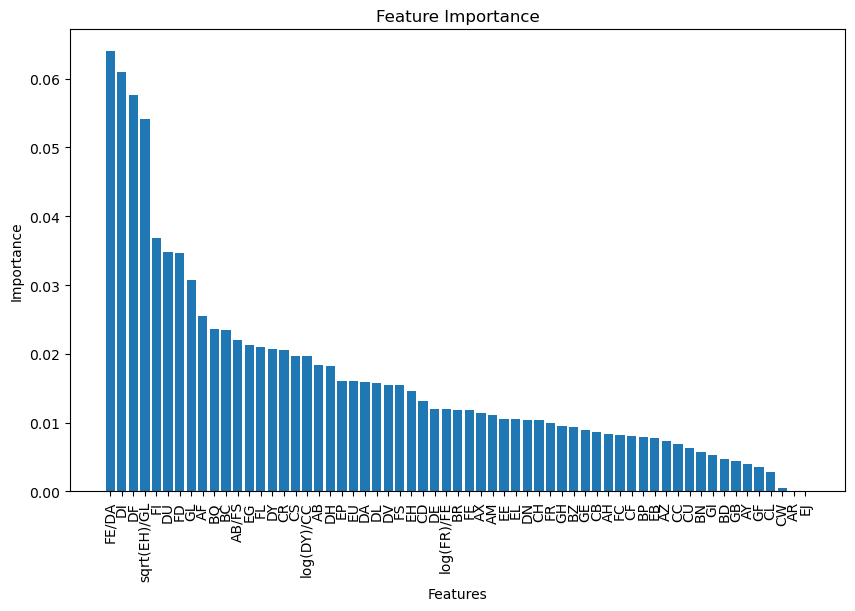

In [15]:
importance = best_model.feature_importances_
feature_names = feature_cols2

# 重要度の高い順に特徴量をソート
sorted_indices = importance.argsort()[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importance)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [16]:
test = test_df.drop('Id', axis=1)
test.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,GE,GF,GH,GI,GL,sqrt(EH)/GL,FE/DA,AB/FS,log(FR)/FE,log(DY)/CC
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf


In [17]:
pred = pd.DataFrame(best_model.predict_proba(test))

In [18]:
sample_submission['Id']      = test_df.reset_index()['Id']
sample_submission["class_0"] = pred[0]
sample_submission["class_1"] = pred[1]
sample_submission.set_index('Id').to_csv('submission.csv')
sample_submission

,Id,class_0,class_1
0,00eed32682bb,0.951892,0.048108
1,010ebe33f668,0.951892,0.048108
2,02fa521e1838,0.951892,0.048108
3,040e15f562a2,0.951892,0.048108
4,046e85c7cc7f,0.951892,0.048108


# **XGB CV 0.192**

# **TabPFNでモデル作成してみる**

In [19]:
y = train_df['Class']
x = train_df[feature_cols2]

device = "cuda" if torch.cuda.is_available() else "cpu"

# クロスバリデーションの設定
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

scores = []
for train_index, test_index in skf.split(x, y):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = TabPFNClassifier(device=device, N_ensemble_configurations=6)
    
    model.fit(X_train.values, y_train.values)

    y_pred_proba = model.predict_proba(X_test.values)[:, 1]
    score = log_loss(y_test.values, y_pred_proba)
    scores.append(score)

mean_score = sum(scores) / len(scores)
for i, score in enumerate(scores):
    print(f'Logloss_Score {i+1}: {score}')

print(f'Logloss_mean: {mean_score}')

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Logloss_Score 1: 0.1632606595435999
Logloss_Score 2: 0.1384550152964725
Logloss_Score 3: 0.27182590958710284
Logloss_Score 4: 0.1700857722838722
Logloss_Score 5: 0.22375679303990623
Logloss_mean: 0.19347682995019072


# **TabPFN CV 0.193**

# **XGBとTabPFNのアンサンブルでモデルを作成する**

In [22]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, ClassifierMixin

In [23]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import xgboost as xgb

class WeightedEnsemble(BaseEstimator, ClassifierMixin):
    def __init__(self, xgb_params=None):
        self.xgb_params = xgb_params
        self.classifiers = [
            xgb.XGBClassifier(**params) for params in self.xgb_params
        ]
        self.classifiers.append(TabPFNClassifier())  # TabPFNClassifierを追加

    def fit(self, X_train, y_train):
        unique_classes, y_train = np.unique(y_train, return_inverse=True)
        self.classes_ = unique_classes
        for classifier in self.classifiers:
            classifier.fit(X_train, y_train)

    def predict_proba(self, X_train):
        probabilities = np.stack([classifier.predict_proba(X_train) for classifier in self.classifiers])
        averaged_probabilities = np.mean(probabilities, axis=0)
        class_0_est_instances = averaged_probabilities[:, 0].sum()
        others_est_instances = averaged_probabilities[:, 1:].sum()
        # Weighted probabilities based on class imbalance
        new_probabilities = averaged_probabilities * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(averaged_probabilities.shape[1])]])
        return new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1)

In [24]:
y = train_df['Class']
x = train_df[feature_cols2]

In [25]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ベストモデルを使用して評価
scores = []
for train_index, test_index in skf.split(x, y):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    model = WeightedEnsemble(xgb_params=[
        {
            'learning_rate': 0.1,
            'n_estimators': 100,
            'random_state': 0,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'eta': 0.1,
            'colsample_bytree': 0.8,
            'max_depth': 3,
            'min_child_weight': 1,
            'subsample': 0.8
        }
    ])
    
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    score = log_loss(y_test, y_pred)
    scores.append(score)

mean_score = sum(scores) / len(scores)
for i, score in enumerate(scores):
    print(f'Logloss_Score {i+1}: {score}')

print(f'Logloss_mean: {mean_score}')

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Logloss_Score 1: 0.20314091030110287
Logloss_Score 2: 0.15733200853431276
Logloss_Score 3: 0.24606138058681165
Logloss_Score 4: 0.23075438550473765
Logloss_Score 5: 0.24376716889799924
Logloss_mean: 0.21621117076499283


In [ ]:
test = test_df.drop('Id', axis=1)
test.head()

In [ ]:
pred = pd.DataFrame(model.predict_proba(test))

In [ ]:
"""
sample_submission['Id']      = test_df.reset_index()['Id']
sample_submission["class_0"] = pred[0]
sample_submission["class_1"] = pred[1]
sample_submission.set_index('Id').to_csv('submission.csv')
sample_submission
"""


# **WeightedEnsemble**
# **LB 0.20 CV 0.216**